# Fine-tuning d'un décodeur

**Llama 3.2 avec la méthode LoRA (Low Rank Adaptation)**

Dans notre projet, on mettra en place un décodeur Llama 3.2 afin de réaliser une tâche de classification. Llama 3.2 est un modèle de langage open-source développé par Meta (2024), il existe plusieurs versions de ce modèle. On utilisera la version 1B qui possède environ 1.24 milliard de paramètres, ce qui est suffisamment léger pour être fine-tuné sur un GPU grand public tout en restant performant pour des tâches comme la classification de texte. Afin d'améliorer l'efficacité de notre modèle, on utilisera la méthode LoRA. Elle permet d'adapter un grand modèle en n'entraînant qu'une fraction de ses paramètres (environ 1%). Au lieu de modifier tous les poids, on ajoute de petites matrices aux couches d'attention, ce qui réduit énormément le coût en mémoire et en temps d'exécution.

---

## 1. Installation et Configuration

In [1]:
# Installation des bibliothèques nécessaires
# transformers : pour charger Llama
# peft : pour l'adaptation LoRA
# trl : pour SFTTrainer (Supervised Fine-Tuning)
!pip install -q transformers>=4.36.0 peft>=0.7.0 \
             datasets>=2.14.0 accelerate>=0.25.0 trl>=0.7.0 scikit-learn

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")

# Désactiver Weights & Biases (évite les problèmes de connexion)
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd  # manipulation de données
import numpy as np  # calculs numériques
import torch  # PyTorch
from datasets import Dataset
from tqdm.auto import tqdm  # barre de progression

# Transformers et PEFT
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType
from trl import SFTTrainer, SFTConfig

# Métriques d'évaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Vérification de la disponibilité du GPU
print(f"CUDA disponible : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU : {torch.cuda.get_device_name(0)}")
    print(
        f"Mémoire GPU : {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} Go"
    )

KeyboardInterrupt: 

---

## 2. Authentification Hugging Face

Llama 3.2 est un modèle "gated" nécessitant une authentification.

In [3]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

# Récupération du token depuis les secrets Kaggle
hf_token = UserSecretsClient().get_secret("HF_TOKEN")
login(token=hf_token)

---

## 3. Chargement et Exploration des Données

In [ ]:
# Chemins vers les fichiers de données
DATA_DIR = "/kaggle/input/nli-french-dataset"

# Chargement des fichiers TSV
df_train = pd.read_csv(f"{DATA_DIR}/nli_fr_train.tsv", sep="\t")
df_test = pd.read_csv(f"{DATA_DIR}/nli_fr_test.tsv", sep="\t")

# Affichage des informations de base
print(f"Train : {len(df_train)} exemples | Test : {len(df_test)} exemples")
print(f"\nDistribution des labels (train) :\n{df_train['label'].value_counts()}")
print(f"\nColonnes : {df_train.columns.tolist()}")

Train : 5010 exemples | Test : 2490 exemples

Distribution des labels (train) :
label
contradiction    1670
entailment       1670
neutral          1670
Name: count, dtype: int64

Colonnes : ['-e premise', 'hypo', 'label']


In [5]:
# Vérification des noms de colonnes et aperçu des données
print("Colonnes du DataFrame:")
print(df_train.columns.tolist())
print("\nPremière ligne:")
print(df_train.iloc[0])

Colonnes du DataFrame:
['-e premise', 'hypo', 'label']

Première ligne:
-e premise    Eh bien, je ne pensais même pas à cela, mais j...
hypo                          Je ne lui ai pas parlé de nouveau
label                                             contradiction
Name: 0, dtype: object


---

## 4. Préparation des Données

Pour utiliser un **décodeur** (Llama) en classification, on reformule la tâche comme une génération de texte avec un prompt structuré.

In [ ]:
def create_prompt(premise: str, hypothesis: str, label: str = None) -> str:
    """
    Crée un prompt formaté pour la tâche NLI.
    Le format instruction/input/output est standard pour les LLMs.

    Args:
        premise: La première phrase (contexte)
        hypothesis: La deuxième phrase (hypothèse à vérifier)
        label: Le label attendu (pour l'entraînement)

    Returns:
        Le prompt formaté
    """
    prompt = f"""### Instruction:
Détermine la relation logique entre la Phrase 1 et la Phrase 2.
Réponds uniquement par : entailment, contradiction, ou neutral.

### Phrase 1:
{premise}

### Phrase 2:
{hypothesis}

### Relation:"""

    # Ajout du label pour l'entraînement
    if label is not None:
        prompt += f" {label}"

    return prompt


def prepare_dataset(df: pd.DataFrame) -> Dataset:
    """
    Convertit un DataFrame pandas en Dataset Hugging Face.

    Args:
        df: DataFrame avec les colonnes premise, hypothesis, label

    Returns:
        Dataset Hugging Face prêt pour l'entraînement
    """
    # Adaptation aux noms de colonnes du dataset
    premise_col = "premise" if "premise" in df.columns else "-e premise"
    hypo_col = "hypo" if "hypo" in df.columns else "hypothesis"

    # Création des prompts pour chaque exemple
    texts = [
        create_prompt(row[premise_col], row[hypo_col], row["label"])
        for _, row in df.iterrows()
    ]

    return Dataset.from_dict({"text": texts, "label": df["label"].tolist()})


# Préparation des datasets
train_dataset = prepare_dataset(df_train)
test_dataset = prepare_dataset(df_test)

print(f"Datasets préparés : {len(train_dataset)} train, {len(test_dataset)} test")
print(f"\nExemple de prompt:\n{train_dataset[0]['text'][:300]}...")

Datasets préparés : 5010 train, 2490 test

Exemple de prompt:
### Instruction:
Détermine la relation logique entre la Phrase 1 et la Phrase 2.
Réponds uniquement par : entailment, contradiction, ou neutral.

### Phrase 1:
Eh bien, je ne pensais même pas à cela, mais j'étais si frustré, et j'ai fini par lui reparler.

### Phrase 2:
Je ne lui ai pas parlé de nou...


---

## 5. Chargement du Modèle Llama 3.2 1B

In [ ]:
MODEL_NAME = "meta-llama/Llama-3.2-1B"

# Chargement du modèle en float16 (demi-précision pour économiser la mémoire)
print("Chargement du modèle...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",  # Placement automatique sur GPU
    torch_dtype=torch.float16,  # Précision 16-bit
    token=hf_token,
)

# Chargement du tokenizer (convertit le texte en tokens)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=hf_token)
tokenizer.pad_token = tokenizer.eos_token  # Llama n'a pas de pad_token par défaut
tokenizer.padding_side = "right"  # Padding à droite pour les décodeurs

print(f"Modèle chargé : {model.num_parameters():,} paramètres")
print(f"Mémoire GPU utilisée : {torch.cuda.memory_allocated() / 1e9:.2f} Go")

Chargement du modèle...


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Modèle chargé : 1,235,814,400 paramètres
Mémoire GPU utilisée : 1.26 Go


---

## 6. Configuration LoRA

**LoRA** (Low-Rank Adaptation) permet d'adapter le modèle en n'entraînant qu'une fraction des paramètres.

In [ ]:
# Activation du gradient checkpointing pour économiser la mémoire
model.gradient_checkpointing_enable()

# Configuration des hyperparamètres LoRA
lora_config = LoraConfig(
    r=16,  # Rang des matrices d'adaptation
    lora_alpha=32,  # Facteur de mise à l'échelle (alpha/r)
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Couches d'attention
    lora_dropout=0.05,  # Dropout pour régularisation
    bias="none",  # Pas d'entraînement des biais
    task_type=TaskType.CAUSAL_LM,  # Tâche de modélisation causale
)

# Application de LoRA au modèle
model = get_peft_model(model, lora_config)

# Affichage du pourcentage de paramètres entraînables
model.print_trainable_parameters()

trainable params: 3,407,872 || all params: 1,239,222,272 || trainable%: 0.2750


Le rang r=16 offre un bon compromis entre un bon temps de calcul et efficacité, permettant de capturer suffisamment d'information pour la tâche NLI tout en gardant le nombre de paramètres entraînables faible (~0.27%). Le ratio alpha/r = 2 est une valeur standard qui stabilise l'apprentissage, et le ciblage des couches d'attention ('q_proj', 'k_proj', 'v_proj', 'o_proj') est recommandé car ce sont les couches les plus importantes pour adapter le comportement du modèle.

---

## 7. Entraînement (Fine-tuning)

In [ ]:
OUTPUT_DIR = "./llama-nli-lora"

# Configuration des paramètres d'entraînement
training_args = SFTConfig(
    output_dir=OUTPUT_DIR,
    num_train_epochs=2,  # Nombre d'epochs
    per_device_train_batch_size=4,  # Batch size par GPU
    gradient_accumulation_steps=4,  # Accumulation pour batch effectif de 16
    learning_rate=1e-4,  # Taux d'apprentissage
    warmup_ratio=0.03,  # Warmup progressif
    optim="adamw_torch",  # Optimiseur AdamW
    max_length=384,  # Longueur max des séquences
    logging_steps=20,  # Fréquence des logs
    logging_first_step=True,
    save_strategy="no",  # Pas de sauvegarde intermédiaire
    fp16=True,  # Entraînement en précision mixte
    dataset_text_field="text",  # Colonne contenant les prompts
    report_to="none",  # Désactive wandb
    gradient_checkpointing=True,  # Économie de mémoire
)

# Création du trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    processing_class=tokenizer,
)

# Informations sur l'entraînement
print(
    f"Batch size effectif : {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}"
)
print(
    f"Nombre de steps par epoch: {len(train_dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)}"
)

Adding EOS to train dataset:   0%|          | 0/5010 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/5010 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/5010 [00:00<?, ? examples/s]

Batch size effectif : 16
Nombre de steps par epoch: 313


Le batch size effectif de 16 (4 × 4 accumulation) est adapté aux contraintes de limite de mémoire du GPU T4 en assurant des gradients assez stables. Le learning rate de '1e-4' est standard pour le fine-tuning LoRA, suffisamment élevé pour converger rapidement sur 2 epochs sans déstabiliser les poids pré-entraînés. Le warmup de 3% permet une montée progressive qui évite les mises à jour brutales tout au début de l'entraînement.

In [ ]:
# Lancement de l'entraînement
print("Début de l'entraînement...")
print("Les logs apparaîtront toutes les 20 steps.")
print("=" * 50)

train_result = trainer.train()

print("=" * 50)
print(f"Entraînement terminé!")
print(f"Loss finale : {train_result.training_loss:.4f}")
print(f"Temps total : {train_result.metrics['train_runtime']:.0f} secondes")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128001}.


Début de l'entraînement...
Les logs apparaîtront toutes les 20 steps.


Step,Training Loss
1,2.795700
20,2.504300
40,1.456100
60,1.355600
80,1.337300
100,1.309200
120,1.290200
140,1.302400
160,1.296400
180,1.297500


Entraînement terminé!
Loss finale : 1.3066
Temps total : 613 secondes


La loss diminue rapidement de 2.80 à ~1.30 dès les 40 premiers steps, indiquant que le modèle apprend efficacement le format de la tâche NLI. La stabilisation autour de 1.20-1.25 durant la deuxième epoch nous montre que le modèle a convergé et qu'un entraînement plus long n'apporterait pas d'amélioration significative sans risquer le surapprentissage.

In [11]:
# Sauvegarde du modèle fine-tuné (uniquement les poids LoRA)
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Modèle sauvegardé dans : {OUTPUT_DIR}")

Modèle sauvegardé dans : ./llama-nli-lora


---

## 8. Évaluation du Modèle

In [ ]:
def predict_nli(model, tokenizer, premise: str, hypothesis: str) -> str:
    """
    Prédit la relation NLI entre deux phrases.

    Args:
        model: Modèle fine-tuné
        tokenizer: Tokenizer associé
        premise: Première phrase
        hypothesis: Deuxième phrase

    Returns:
        Label prédit (entailment, contradiction, neutral)
    """
    # Création du prompt sans label
    prompt = create_prompt(premise, hypothesis)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Génération de la réponse
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=False,  # Génération déterministe
            pad_token_id=tokenizer.eos_token_id,
        )

    # Décodage et extraction du label
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response.split("### Relation:")[-1].strip().lower()

    # Mapping vers les labels (gère les variations comme "entail")
    if "entail" in response:
        return "entailment"
    elif "contradict" in response:
        return "contradiction"
    elif "neutral" in response:
        return "neutral"
    else:
        return "unknown"

In [ ]:
# Prédictions sur le jeu de test
print("Évaluation sur le jeu de test...")

# Adaptation aux noms de colonnes
premise_col = "premise" if "premise" in df_test.columns else "-e premise"
hypo_col = "hypo" if "hypo" in df_test.columns else "hypothesis"

predictions = []
true_labels = df_test["label"].tolist()

# Boucle de prédiction avec barre de progression
for _, row in tqdm(df_test.iterrows(), total=len(df_test)):
    pred = predict_nli(model, tokenizer, row[premise_col], row[hypo_col])
    predictions.append(pred)

print("Évaluation terminée.")

Évaluation sur le jeu de test...


  0%|          | 0/2490 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
Caching is incompatible with gradient checkpointing in LlamaDecoderLayer. Setting `past_key_values=None`.


Évaluation terminée.


---

## 9. Résultats et Métriques

In [ ]:
# Calcul de l'accuracy
accuracy = accuracy_score(true_labels, predictions)

print(f"\n{'=' * 50}")
print(f"RÉSULTATS - Llama 3.2 1B + LoRA")
print(f"{'=' * 50}")
print(f"\nAccuracy : {accuracy:.4f} ({accuracy * 100:.2f}%)")
print(f"\nRapport de classification :")
print(classification_report(true_labels, predictions, digits=4))


RÉSULTATS - Llama 3.2 1B + LoRA

Accuracy : 0.7080 (70.80%)

Rapport de classification :
               precision    recall  f1-score   support

contradiction     0.7902    0.7217    0.7544       830
   entailment     0.7198    0.7675    0.7429       830
      neutral     0.6222    0.6349    0.6285       830

     accuracy                         0.7080      2490
    macro avg     0.7107    0.7080    0.7086      2490
 weighted avg     0.7107    0.7080    0.7086      2490



L'accuracy de 70.80% dépasse largement la baseline aléatoire (33%) et démontre l'efficacité du fine-tuning LoRA sur un décodeur pour une tâche de classification. La classe *neutral* obtient le F1-score le plus faible (0.63) car elle est plus ambiguë, ce qui est un phénomène classique en NLI où les frontières entre neutralité et implication/contradiction sont souvent floues.

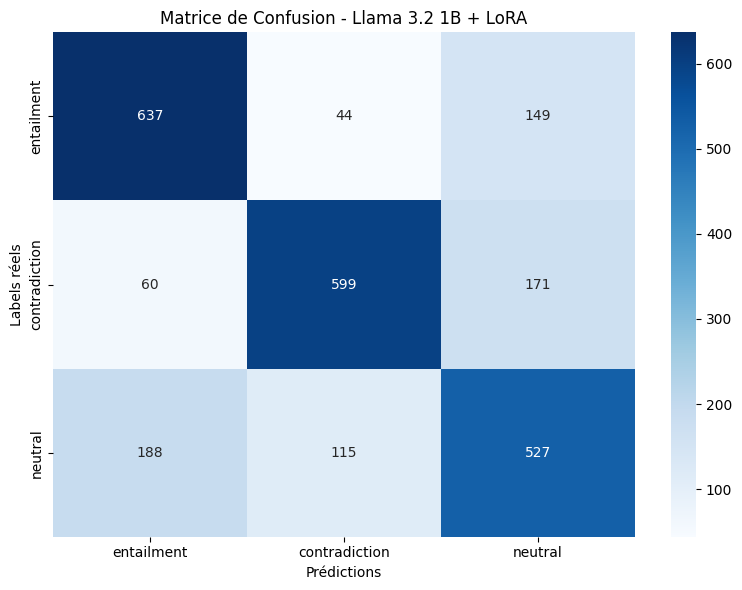

In [ ]:
# Matrice de confusion
labels = ["entailment", "contradiction", "neutral"]
cm = confusion_matrix(true_labels, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
)
plt.title("Matrice de Confusion - Llama 3.2 1B + LoRA")
plt.xlabel("Prédictions")
plt.ylabel("Labels réels")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150)
plt.show()

On observe que les erreurs se concentrent principalement entre *neutral* et les deux autres classes, confirmant la difficulté du modèle à distinguer les cas ambigus. Les classes *entailment* et *contradiction* sont relativement bien séparées entre elles, ce qui indique que le modèle a bien appris les relations logiques opposées.

In [ ]:
# Sauvegarde des prédictions dans un fichier CSV
premise_col = "premise" if "premise" in df_test.columns else "-e premise"
hypo_col = "hypo" if "hypo" in df_test.columns else "hypothesis"

results_df = pd.DataFrame(
    {
        "premise": df_test[premise_col],
        "hypothesis": df_test[hypo_col],
        "true_label": true_labels,
        "predicted": predictions,
        "correct": [t == p for t, p in zip(true_labels, predictions)],
    }
)
results_df.to_csv("predictions.csv", index=False)

# Résumé final de la configuration
print(f"\n{'=' * 50}")
print("CONFIGURATION EXPÉRIMENTALE")
print(f"{'=' * 50}")
print(f"Modèle : Llama 3.2 1B")
print(f"LoRA : r={lora_config.r}, alpha={lora_config.lora_alpha}")
print(f"Epochs : {training_args.num_train_epochs}")
print(f"Learning rate : {training_args.learning_rate}")
print(
    f"Batch size : {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}"
)
print(f"\nAccuracy finale : {accuracy * 100:.2f}%")


CONFIGURATION EXPÉRIMENTALE
Modèle : Llama 3.2 1B
LoRA : r=16, alpha=32
Epochs : 2
Learning rate : 0.0001
Batch size : 16

Accuracy finale : 70.80%


---

## 4. Résultats expérimentaux

### 4.1 Données et configuration

| **Paramètre** | **Valeur** |
|---|---|
| Modèle | Llama 3.2 1B |
| Paramètres entraînables | 0.52% |
| Epochs | 2 |
| Batch size | 16 |
| Learning rate | $1 \times 10^{-4}$ |

Ces hyperparamètres ont été choisis pour avoir un compromis entre un resultats satisfaisant et un temps de calcul efficace. 

### 4.2 Performances

| **Classe** | **Precision** | **Recall** | **F1-score** | **Support** |
|---|---|---|---|---|
| Contradiction | 0.7902 | 0.7217 | 0.7544 | 830 |
| Entailment | 0.7198 | 0.7675 | 0.7429 | 830 |
| Neutral | 0.6222 | 0.6349 | 0.6285 | 830 |
| **Accuracy** | – | – | **0.7080** | 2490 |
| Macro avg | 0.7107 | 0.7080 | 0.7086 | 2490 |
---

Le modèle atteint une accuracy de **70.80%**, bien au-dessus de la baseline aléatoire (33.33%). Les classes *contradiction* et *entailment* obtiennent des F1-scores similaires (~0.75), tandis que la classe *neutral* présente des performances inférieures (F1 = 0.63), ce qui s'explique par sa nature plus ambiguë. En n'entraînant que 0.52% des paramètres, LoRA permet d'adapter efficacement un décodeur à une tâche de classification.

---

## 10. Conclusion

Ce projet a permis d'explorer la mise en place du modèle Llama 3.2 1B à la tâche d'inférence en langage naturel (NLI) en français en utilisant la méthode LoRA. Cette technique de fine-tuning nous a permis d'entraîner seulement 0.5% des paramètres du modèle tout en obtenant une accuracy de **70.80%**. On observe aussi que la classe *neutral* obtient un F1-score plus faible (0.63) que les classes *contradiction* et *entailment* (~0.75), une différence qui s'explique peut-être par l'ambiguïté de cette catégorie. Toutefois, ces résultats nous montrent qu'un décodeur autorégressif peut être adapté de manière satisfaisante à une tâche de classification sans nécessiter de ressources matérielles importantes.